# Navigation

---
**Note**: 

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# import general stuff
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# import specific / own stuff
from dqn_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. [Optional] Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. [Optional] Let's train an agent!

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Define agent and start training with DQN
The training can be skipped and an trained agent can be loaded in section 5.

In [7]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_nEpisodes=500):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    last_reward_vec = np.zeros(max_t)  # reset reward vector, only for last episode
    eps_decay_linear = (eps_start-eps_end)/eps_nEpisodes # compute linear epsilon decay rate
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset unity enviroment
        state = env_info.vector_observations[0]            # get the current state 
        score = 0
        for t in range(max_t):
            # choose action and perform it
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            # send env data to agent and initiate learning
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            
            # do some tracking on the rewards
            state = next_state
            score += reward
            if i_episode == n_episodes: last_reward_vec[t] = reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_start - eps_decay_linear*i_episode) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            # yeaaah, we did it!
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # save current agent
            checkpoint = {'input_size': state_size,
              'output_size': action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_target.hidden_layers],
              'state_dict': agent.qnetwork_target.state_dict()}
            torch.save(checkpoint, './data/checkpoint.pth')
            break
    return scores, last_reward_vec

Episode 100	Average Score: 0.31
Episode 200	Average Score: 2.32
Episode 300	Average Score: 4.46
Episode 400	Average Score: 7.93
Episode 500	Average Score: 11.21
Episode 551	Average Score: 13.00
Environment solved in 551 episodes!	Average Score: 13.00


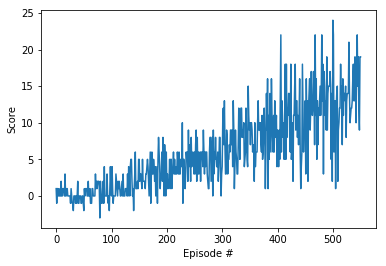

In [8]:
# create agent and train
agent = Agent(state_size, action_size, 1)        # initialize agent
scores, last_reward_vec = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('./data/score_over_episodes.png')
plt.show()

#### [Optional] watch agent to get a feeling how well it performs

Number of actions taken: 299
Reached score: 15.0


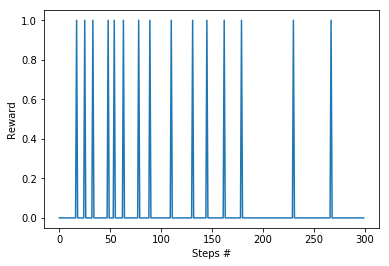

In [9]:
# reset the environment and initialize some stuff
env_info = env.reset(train_mode=False)[brain_name]  # reset unity enviroment
state = env_info.vector_observations[0]             # get the current state 
score = 0.0                                         # set score to zero
num_steps = 10000                                   # choose how many steps you want to watch the agent
all_rewards = []                                    # initalize to zero to see all rewards collected during episode

for t in range(num_steps):
    # choose action and perform it
    action = int(agent.act(state, 0.0))            # choose action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    
    # send env data to agent and initiate learning
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, next_state, done)
    
    # do some tracking on the rewards
    state = next_state
    score += reward
    all_rewards.append(reward)
    if done:
        break 

print('Number of actions taken: {}'.format(t))
print('Reached score: {}'.format(score))
# plot the rewards
fig = plt.figure()
plt.plot(np.arange(len(all_rewards)), all_rewards)
plt.ylabel('Reward')
plt.xlabel('Steps #')
plt.show()

### 5. Load a trained agent
#### manually save agent (remove # if desired)

In [10]:
# save learned agent if desired
checkpoint = {'input_size': state_size,
              'output_size': action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
              'state_dict': agent.qnetwork_local.state_dict()}
#torch.save(checkpoint, './data/lastworkingcheckpoint_local.pth')

checkpoint = {'input_size': state_size,
              'output_size': action_size,
              'hidden_layers': [each.out_features for each in agent.qnetwork_target.hidden_layers],
              'state_dict': agent.qnetwork_target.state_dict()}
#torch.save(checkpoint, './data/lastworkingcheckpoint_target.pth')

#### load the agent

In [11]:
# load from save
agent = Agent(state_size, action_size, 123)
checkpoint = torch.load('./data/lastworkingcheckpoint_local.pth')
agent.qnetwork_local.load_state_dict(checkpoint['state_dict'])
checkpoint = torch.load('./data/lastworkingcheckpoint_target.pth')
agent.qnetwork_target.load_state_dict(checkpoint['state_dict'])

RuntimeError: Error(s) in loading state_dict for QNetwork:
	size mismatch for hidden_layers.0.weight: copying a param of torch.Size([37, 37]) from checkpoint, where the shape is torch.Size([111, 37]) in current model.
	size mismatch for hidden_layers.0.bias: copying a param of torch.Size([37]) from checkpoint, where the shape is torch.Size([111]) in current model.
	size mismatch for hidden_layers.1.weight: copying a param of torch.Size([37, 37]) from checkpoint, where the shape is torch.Size([111, 111]) in current model.
	size mismatch for hidden_layers.1.bias: copying a param of torch.Size([37]) from checkpoint, where the shape is torch.Size([111]) in current model.
	size mismatch for output.weight: copying a param of torch.Size([4, 37]) from checkpoint, where the shape is torch.Size([4, 111]) in current model.

#### do the simulation

In [ ]:
# reset the environment and initialize some stuff
env_info = env.reset(train_mode=False)[brain_name]  # reset unity enviroment
state = env_info.vector_observations[0]             # get the current state 
score = 0.0                                         # set score to zero
num_steps = 10000                                   # choose how many steps you want to watch the agent
all_rewards = []                                    # initalize to zero to see all rewards collected during episode

for t in range(num_steps):
    # choose action and perform it
    action = int(agent.act(state, 0.0))            # choose action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    
    # send env data to agent and initiate learning
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, next_state, done)
    
    # do some tracking on the rewards
    state = next_state
    score += reward
    all_rewards.append(reward)
    if done:
        break 

print('Number of actions taken: {}'.format(t))
print('Reached score: {}'.format(score))
# plot the rewards
fig = plt.figure()
plt.plot(np.arange(len(all_rewards)), all_rewards)
plt.ylabel('Reward')
plt.xlabel('Actions #')
plt.show()

All done, closing environment

In [ ]:
env.close()